**The goal** of this project is to scrape the information about members in german parliament from its official website.

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
from urllib.request import urlopen

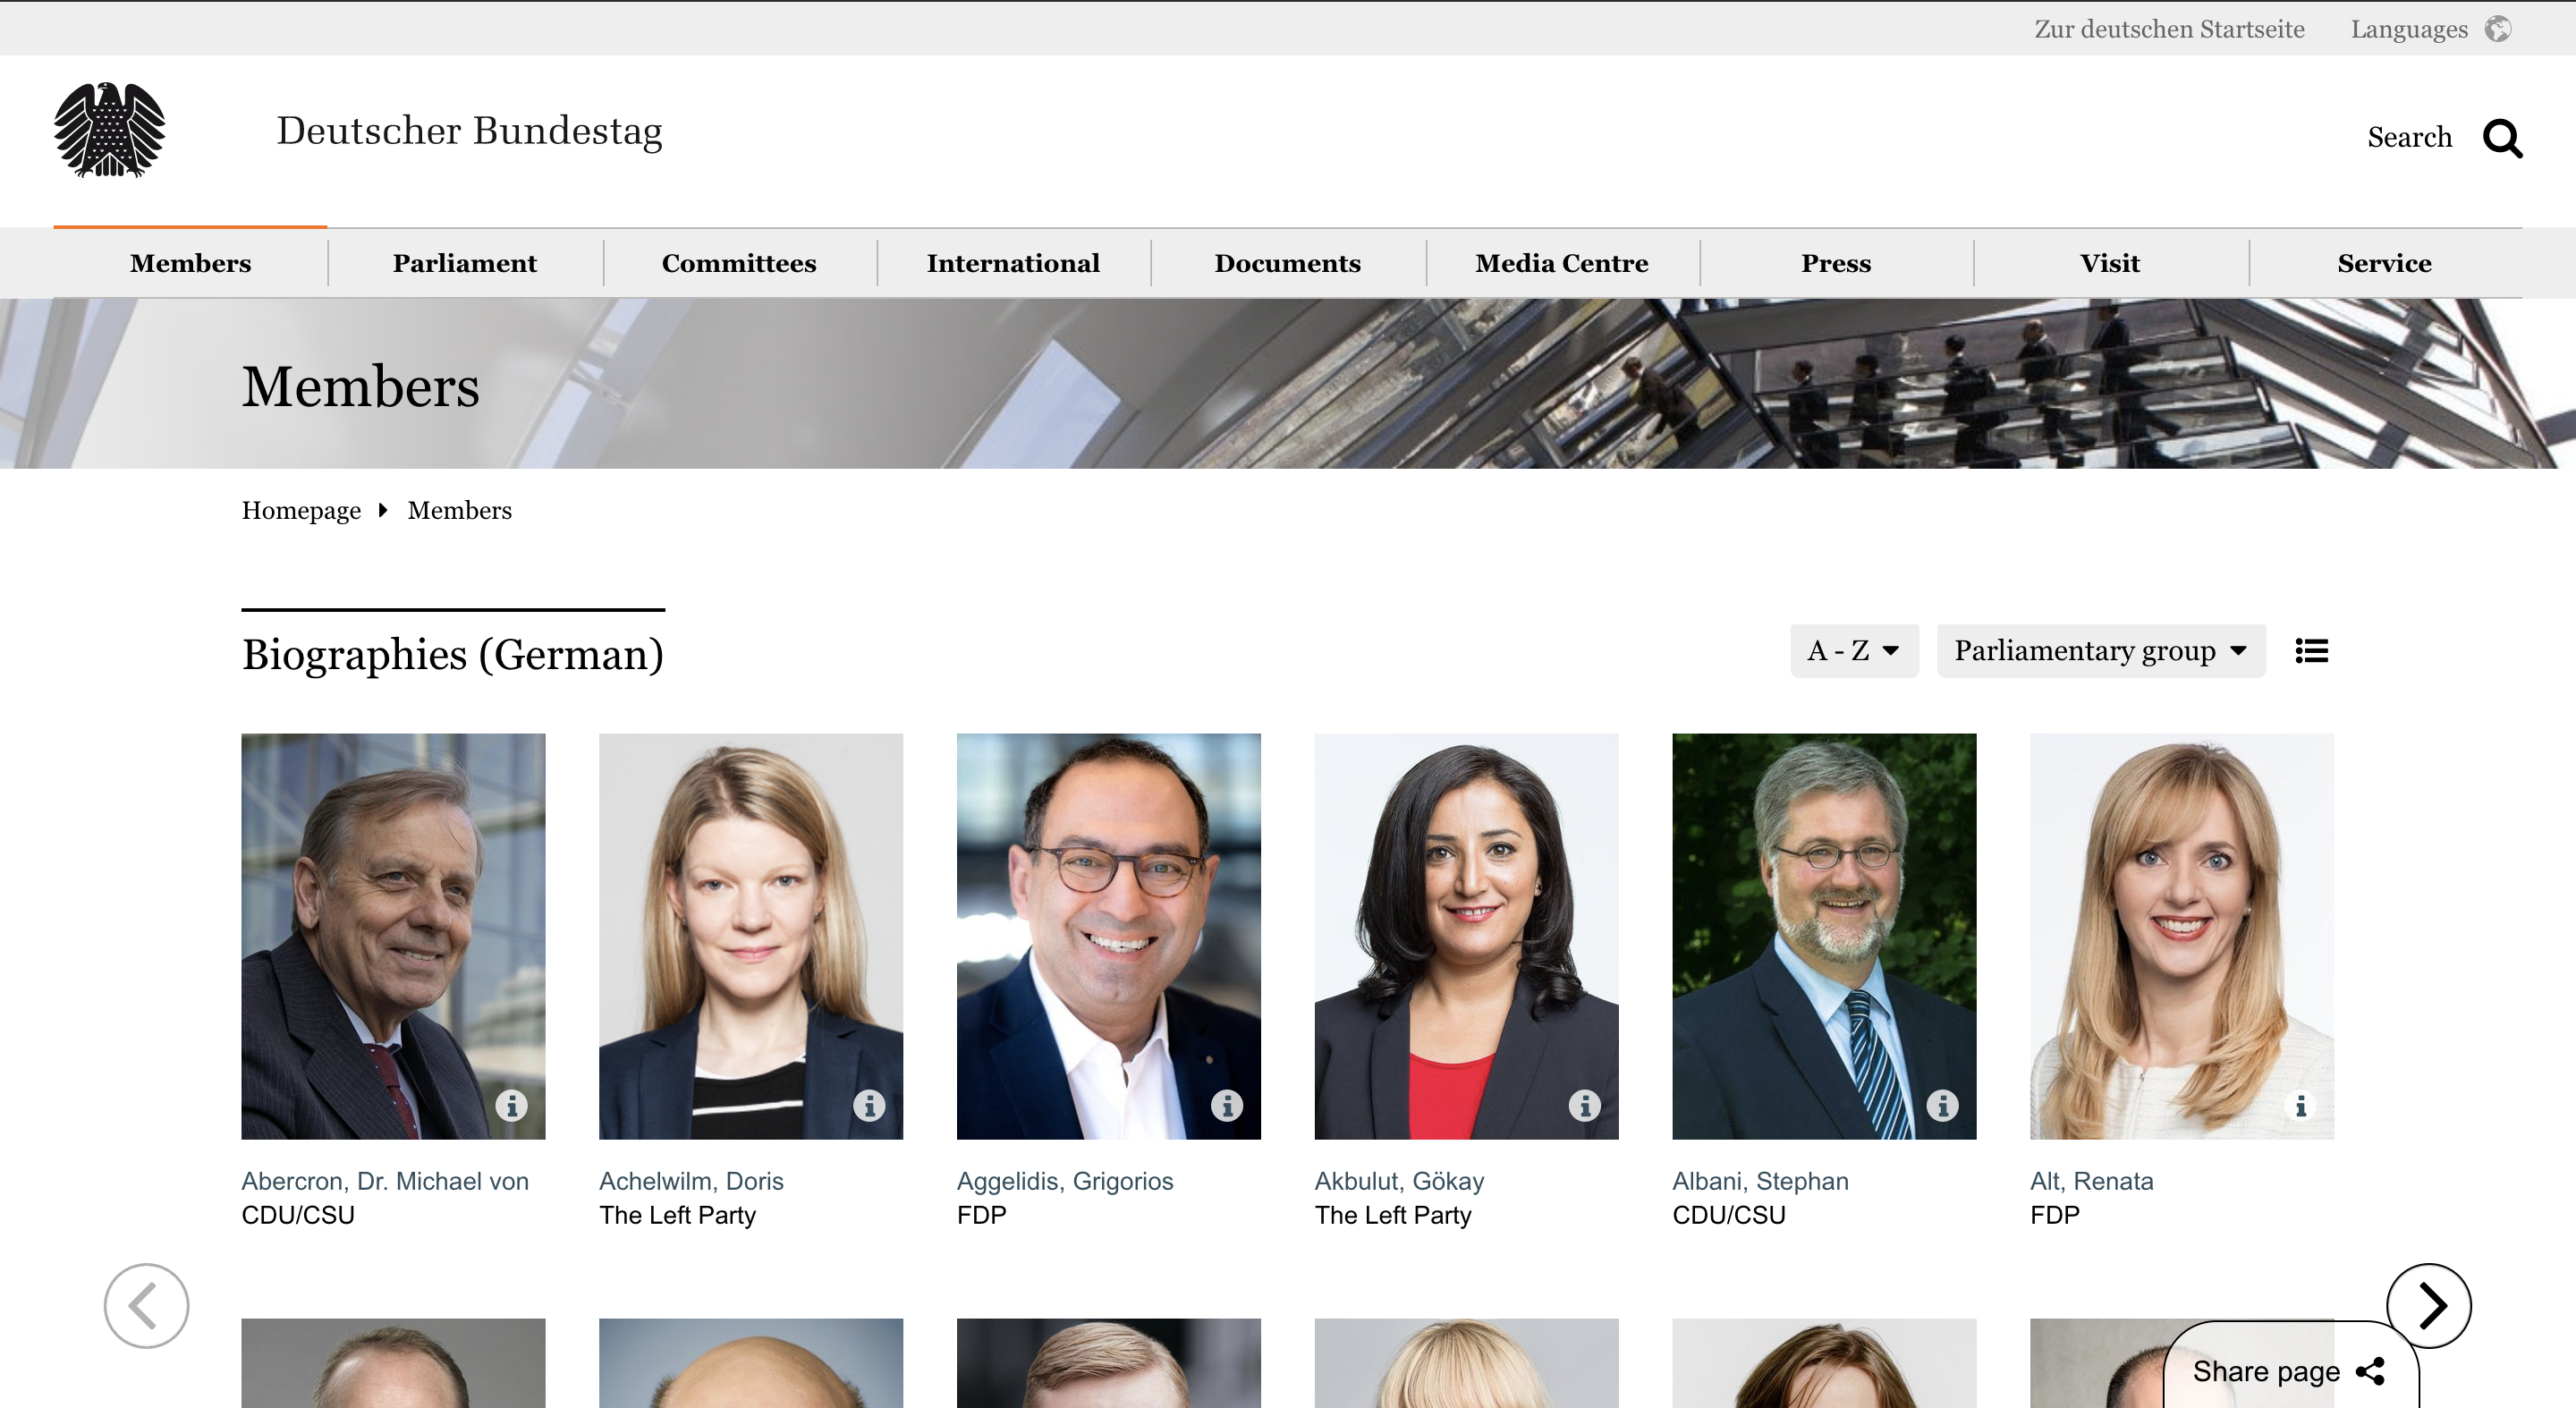

From pages above, we will get the name, the party and the link to the webpage of each parliament member.

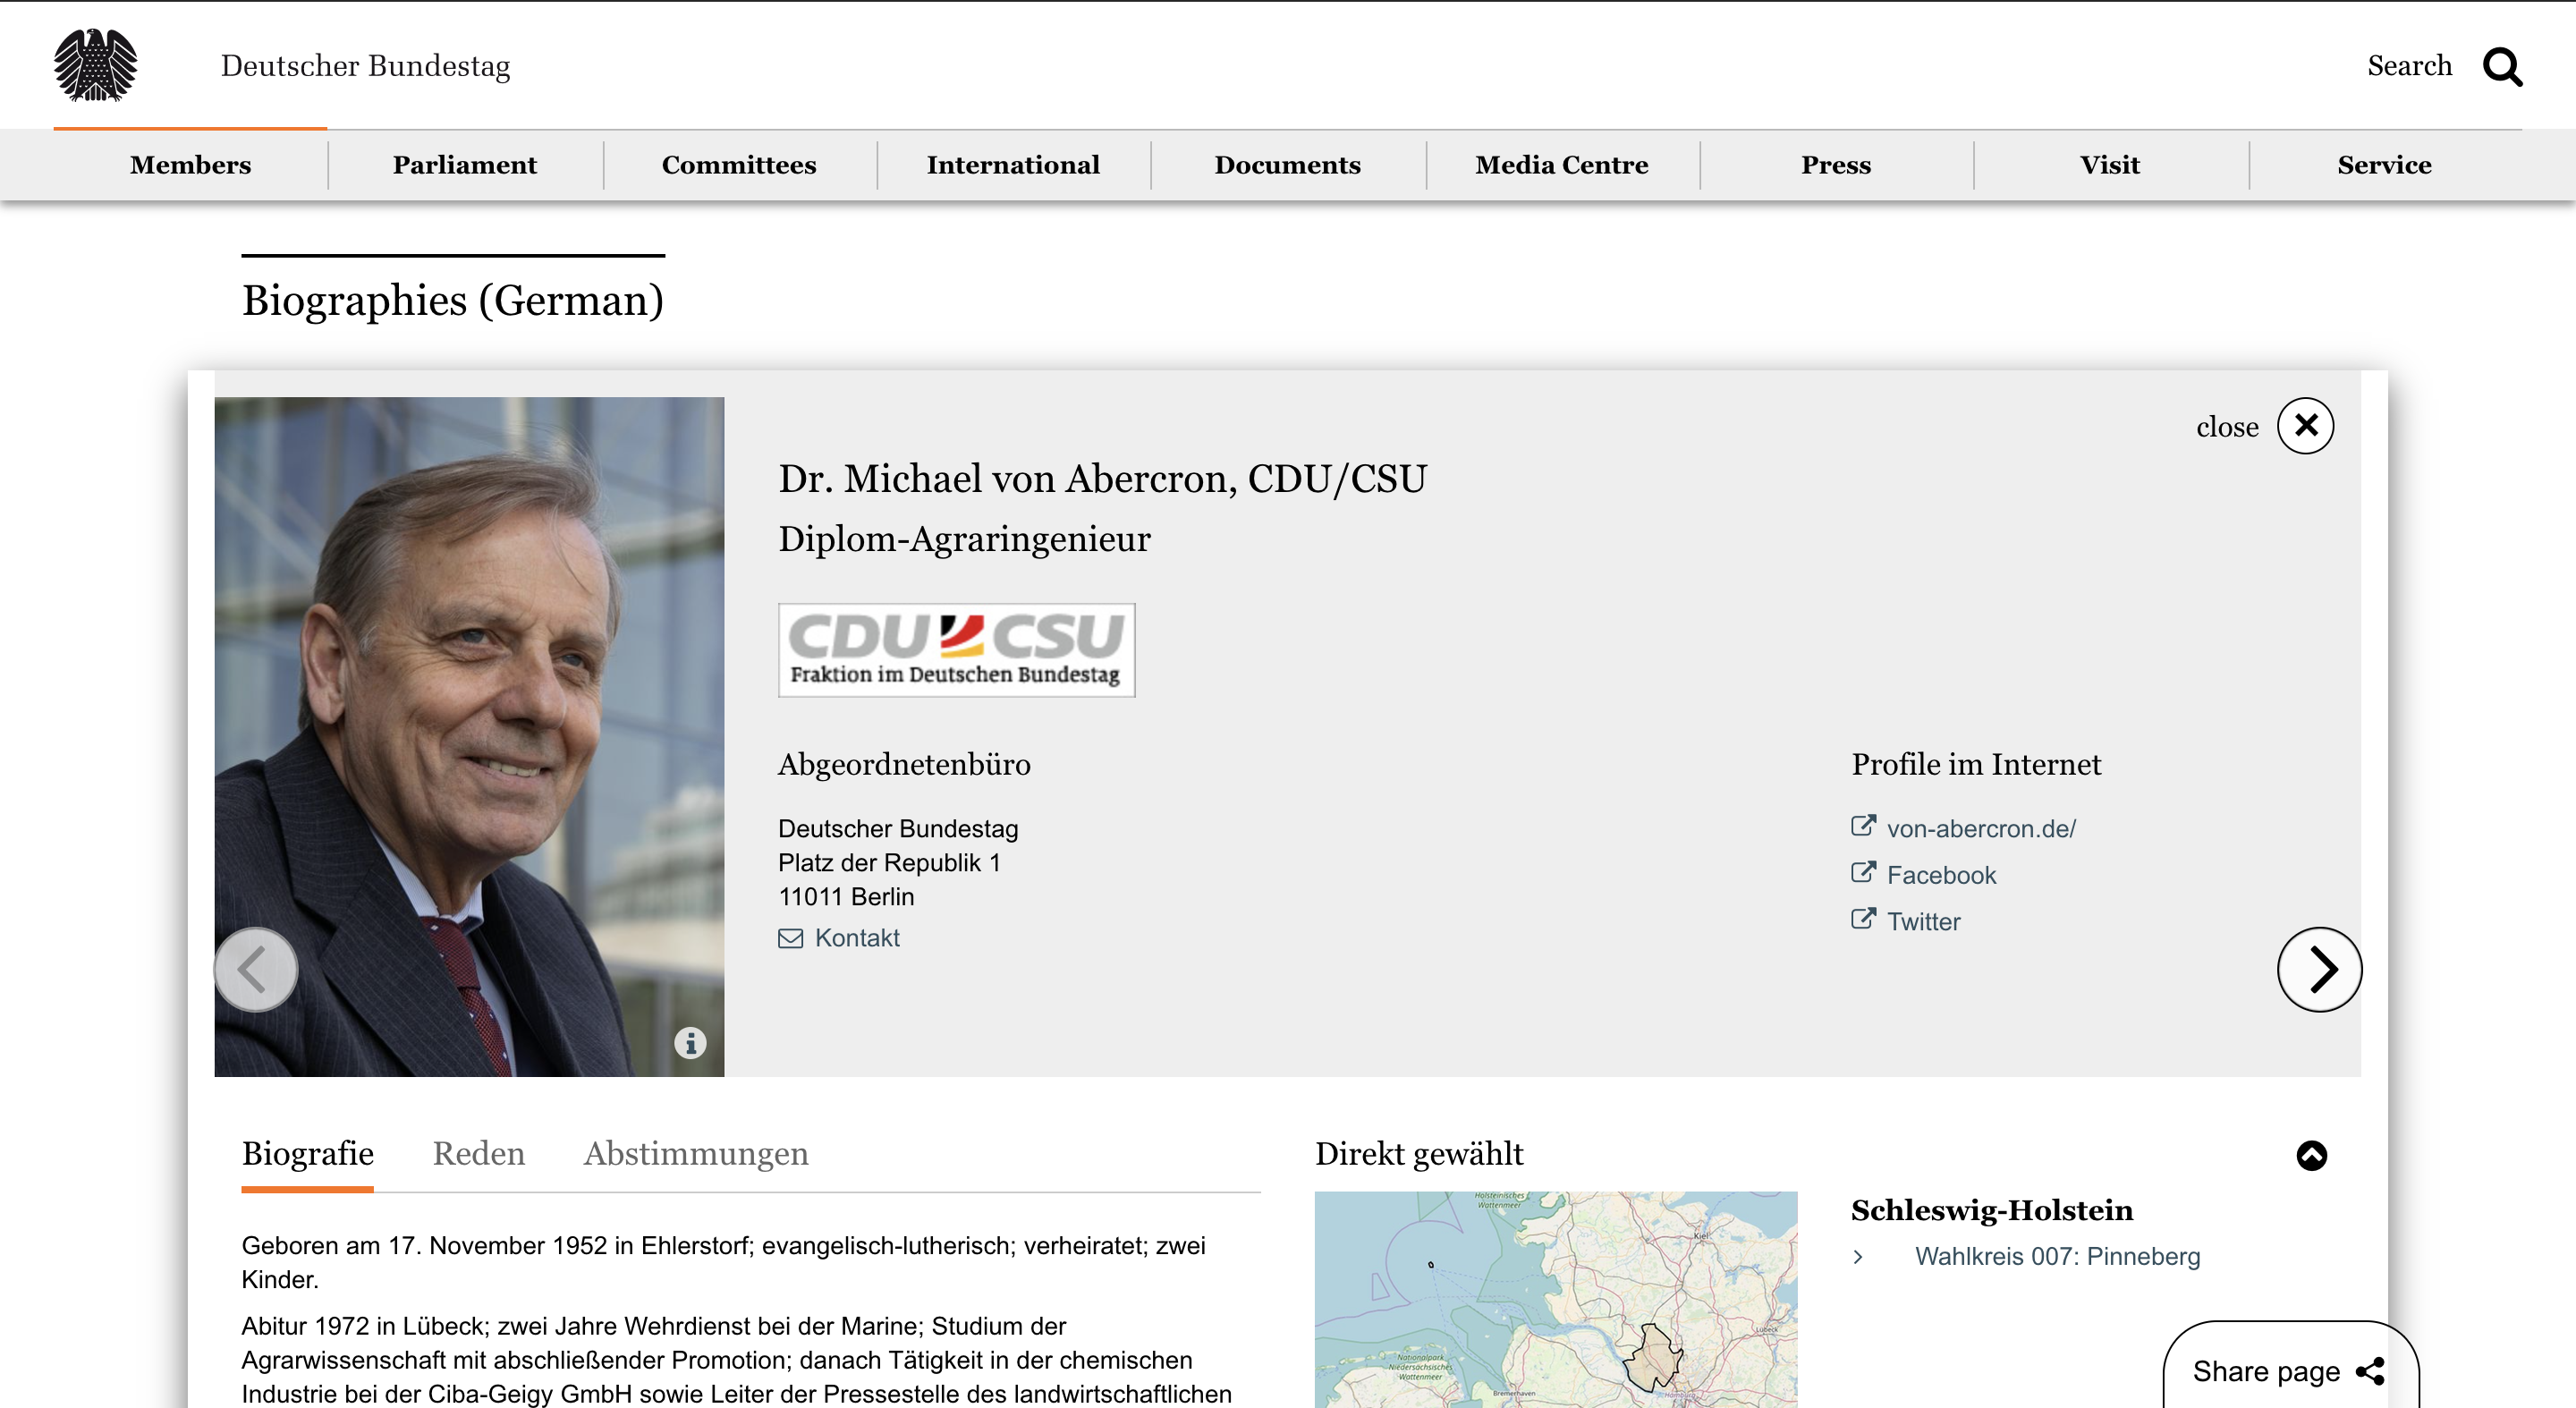

Then, after visiting each personal page, we will retrieve the contacts: the type(e.g. Twitter) and the correspondent link to it.

In [2]:
#the link for the first page with no offset
url = 'https://www.bundestag.de/ajax/filterlist/en/members/453158-453158?limit=20&noFilterSet=true&offset=0'

In [3]:
html = requests.get(url) 
soup = BeautifulSoup(html.content, 'lxml')

In [120]:
%%time #timer 

names = []
positions = []
contacts_total = []
#for each page
for page_number in range(1, 20): #in order to save the time i'll scrape only the part of the pages
    url_final = f'https://www.bundestag.de/ajax/filterlist/en/members/453158-453158?limit=20&noFilterSet=true&offset={page_number}'
    html_final = requests.get(url_final)
    soup_final = BeautifulSoup(html_final.content, 'lxml')
    #for each member of the parlament
    for row in soup_final.find_all('div', class_ = 'col-xs-4 col-sm-3 col-md-2 bt-slide'):
        name = row.find('div', class_ = 'bt-bild-info-text').find("p").text.strip()
        position = row.find('div', class_ = 'bt-teaser-person-text').find("p", class_ = 'bt-person-fraktion').text.strip()
        ref = row.find('a', class_ = 'bt-open-in-overlay', href = True)['href'] #getting link to the personal page with contacts
        html2 = requests.get(ref)
        soup2 = BeautifulSoup(html2.content, 'lxml')  #making another soup object
        #getting contacts on each page
        contacts = soup2.find('ul',class_ = 'bt-linkliste')
        length = len(contacts.find_all('li'))
        contacts_dict = {}
        for i in range(length):
            try: #extracting the contacts if there are any
                name_cont = contacts.find_all('li')[i].find('a', href = True).text.strip()
            except:
                name_cont = 'No_contacts'
            try:
                address = contacts.find_all('li')[i].find('a', href = True)['href']
            except:
                address = 'No_address'
            contacts_dict[name_cont] = address

         #appending all retrieved information to the lists   
        names.append(name)
        positions.append(position)
        contacts_total.append(contacts_dict)
    print(f"Page {page_number} is scraped successfully") #for tracing the process


Page 1 is scraped successfully
Page 2 is scraped successfully
Page 3 is scraped successfully
Page 4 is scraped successfully
Page 5 is scraped successfully
Page 6 is scraped successfully
Page 7 is scraped successfully
Page 8 is scraped successfully
Page 9 is scraped successfully
Page 10 is scraped successfully
Page 11 is scraped successfully
Page 12 is scraped successfully
Page 13 is scraped successfully
Page 14 is scraped successfully
Page 15 is scraped successfully
Page 16 is scraped successfully
Page 17 is scraped successfully
Page 18 is scraped successfully
Page 19 is scraped successfully
CPU times: user 35.2 s, sys: 655 ms, total: 35.9 s
Wall time: 1min 58s


In [177]:
#creating the dataframe
df = pd.DataFrame({'name' : names,
             'position' : positions,
             'contacts' : contacts_total})

In [178]:
#looking at the first rows of the data
df.head()

name        position  \
0      Doris Achelwilm  The Left Party   
1  Grigorios Aggelidis             FDP   
2        Gökay Akbulut  The Left Party   
3       Stephan Albani         CDU/CSU   
4           Renata Alt             FDP   

                                            contacts  
0  {'doris-achelwilm.de': 'http://www.doris-achel...  
1  {'grigorios-aggelidis.de': 'http://www.grigori...  
2  {'goekay-akbulut.de': 'https://goekay-akbulut....  
3  {'stephan-albani.de': 'http://www.stephan-alba...  
4  {'renata-alt.de': 'http://www.renata-alt.de', ...

In [180]:
#splitting the contacts column by keys(or sources, e.g. mail,Facebook, Twitter, etc) and values(links)
sources = []
links = []
for cont in df['contacts']:
    sources.append(' , '.join(list(cont.keys())))
    links.append(' , '.join(list(cont.values())))

In [179]:
df['position'].value_counts()

SPD                       150
CDU/CSU                   101
Alliance 90/The Greens     67
FDP                        30
The Left Party             26
AfD                         6
Name: position, dtype: int64

In [181]:
df.rename(columns = {'contacts' : 'contacts_full_info'}, inplace = True) #renaming the column

In [182]:
df['type_of_contact'] = sources #assigning new columns
df['links'] = links

In [183]:
#final dataset
df.head()

name        position  \
0      Doris Achelwilm  The Left Party   
1  Grigorios Aggelidis             FDP   
2        Gökay Akbulut  The Left Party   
3       Stephan Albani         CDU/CSU   
4           Renata Alt             FDP   

                                  contacts_full_info  \
0  {'doris-achelwilm.de': 'http://www.doris-achel...   
1  {'grigorios-aggelidis.de': 'http://www.grigori...   
2  {'goekay-akbulut.de': 'https://goekay-akbulut....   
3  {'stephan-albani.de': 'http://www.stephan-alba...   
4  {'renata-alt.de': 'http://www.renata-alt.de', ...   

                                     type_of_contact  \
0  doris-achelwilm.de , Facebook , Twitter , Inst...   
1  grigorios-aggelidis.de , Facebook , Twitter , ...   
2  goekay-akbulut.de , Facebook , Twitter , Insta...   
3                                  stephan-albani.de   
4                           renata-alt.de , Facebook   

                                               links  
0  http://www.doris-achelwilm.de/ , https://www.f...  
1  http://www.grigorios-aggelidis.de , https://ww...  
2  https://goekay-akbulut.de/ , https://www.faceb...  
3                       http://www.stephan-albani.de  
4  http://www.renata-alt.de , https://www.faceboo...

Text(0, 0.5, 'Party')

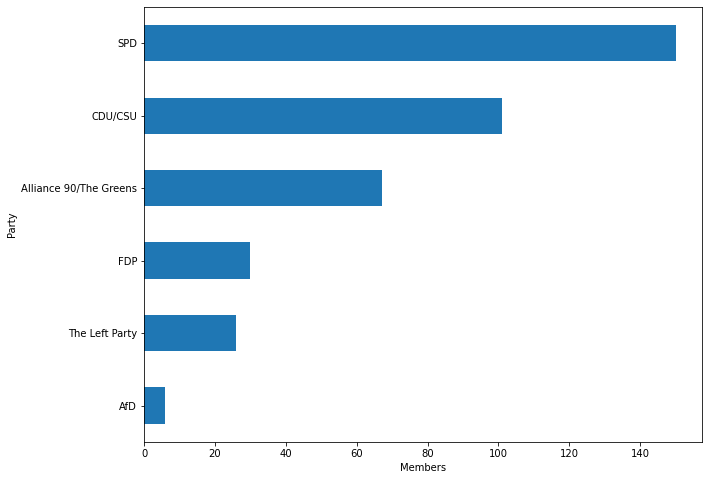

In [188]:
#for my personal interest, i ll check the distribution of parties in Bundestag:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 8))
df['position'].value_counts(ascending = True).plot(kind = 'barh')
plt.xlabel('Members')
plt.ylabel('Party')

In [189]:
#saving the data to csv file
df.to_csv('bundestag_members.csv')